# Change in labor capacity


The fraction of the total capacity lost is given by

$$
Loss = \tfrac{1}{2}(1+ERF \left( \frac{WBGT-Prod_{mean}}{Prod_{SD} * \sqrt{2}} \right))
$$

Where WBGT is WBGTmax, WBGTmean or WBGThalf.  

| Work level | $Prod_{mean}$ | $Prod_{SD}$ |
|------------|---------------|-------------|
| 200        | 35.53         | 3.94        |
| 300        | 33.49         | 3.94        |
| 400        | 32.47         | 4.16        |



In [5]:
%matplotlib inline

from pathlib import Path


import numpy as np
import scipy as sp
import pandas as pd
# import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from numba import jit
from scipy import stats
from scipy.special import erf
# from math import erf

from tqdm import tnrange, tqdm_notebook
from config import DATA_SRC, WEATHER_SRC

import population_tools

In [74]:
# @jit(nopython=True, nogil=True)
def labour_loss(wbgt, prod_mean, prod_sd):
    '''
    ..math:
        Loss = (1+ERF((WBGT-Prod_{mean})/(Prod_{SD} * \sqrt{2})))/2

    Args:
         WBGT is WBGTmax, WBGTmean or WBGThalf in Kelvin
         prod_mean is the mean productivity coefficient for a given power level
         prod_sd is the standard deviation coefficient for a given power level
    
    '''
    root2 = 1.4142135623730951 # np.sqrt(2)
    return (1 + erf(((wbgt - 273.15) - prod_mean) / (prod_sd * root2))) / 2



In [75]:
power_level_data = {
    200: (35.53,  3.94),
    300: (33.49, 3.94),
    400: (32.47, 4.16)
    }

## Plot the labour capacity function

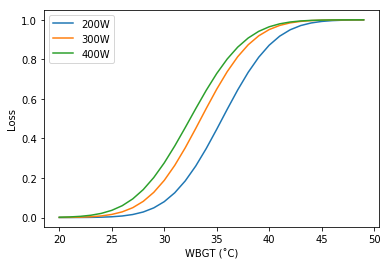

In [76]:
_wbgt = np.arange(20, 50, 1) + 273.15
labourcapacity = labour_loss(_wbgt, 35.53, 3.94)
plt.plot(_wbgt - 273.15, labourcapacity, label='200W')
labourcapacity = labour_loss(_wbgt, 33.49, 3.94)
plt.plot(_wbgt- 273.15, labourcapacity, label='300W')
labourcapacity = labour_loss(_wbgt, 32.47, 4.16)
plt.plot(_wbgt- 273.15, labourcapacity, label='400W')
plt.xlabel('WBGT (˚C)')
plt.ylabel('Loss')
plt.legend()

## Apply to WBGT mean, max, half

In [97]:
wbgt_mean = xr.open_mfdataset(
    str(WEATHER_SRC / 'ecmwf' / 'daily_wbgtmean'/ 'wbgt_mean_*.nc'),
    chunks={'time':100}
                             )
wbgt_max = xr.open_mfdataset(
    str(WEATHER_SRC / 'ecmwf' / 'daily_wbgtmax'/ 'wbgt_max_*.nc'),
    chunks={'time':100}
)

wbgt_half = xr.open_mfdataset(
    str(WEATHER_SRC / 'ecmwf' / 'daily_wbgthalf'/ 'wbgt_half_*.nc'),
    chunks={'time':100}
)

In [96]:
# wbgt_mean = xr.open_mfdataset(
#     str(WEATHER_SRC / 'ecmwf' / 'daily_wbgtmean'/ 'wbgt_mean_20*.nc'),
#     chunks={'time':100}
#                              )
# wbgt_max = xr.open_mfdataset(
#     str(WEATHER_SRC / 'ecmwf' / 'daily_wbgtmax'/ 'wbgt_max_20*.nc'),
#     chunks={'time':100}
# )

# wbgt_half = xr.open_mfdataset(
#     str(WEATHER_SRC / 'ecmwf' / 'daily_wbgthalf'/ 'wbgt_half_20*.nc'),
#     chunks={'time':100}
# )

In [49]:
def hours_capacity_loss_ufunc(wbgt_mean, wbgt_max, wbgt_half, power_level):
    """
    model hourly WBGT using the 4+4+4 method giving a close approximation 
    to the hourly WBGT during the day. 4 hours per day at WBGTmax, 4 hours 
    at WBGThalf, and 4 hours at WBGTmean.
    
    2 extra conditions:  
    as people take micro-breaks during the hour we assume any work hours
    lost less than 10% is no work hours lost, and as everyone can do at 
    least 6 minutes/hour work even under extreme conditions, we assume 90% 
    work hours lost is a maximum.
    
    """
    power_level_data = {
        200: (35.53,  3.94),
        300: (33.49, 3.94),
        400: (32.47, 4.16)
        }
    
    prod_mean, prod_sd = power_level_data[float(power_level)]
    
    
    # Calculate the labour loss and clip it.
    loss_mean = labour_loss(wbgt_mean, prod_mean, prod_sd)
    loss_mean = xr.where(loss_mean < 0.1, 0, loss_mean)
    loss_mean = xr.where(loss_mean > 0.9, 0.9,  loss_mean)
    
    
    loss_max = labour_loss(wbgt_max, prod_mean, prod_sd)
    loss_max = xr.where(loss_max < 0.1, 0, loss_max)
    loss_max = xr.where(loss_max > 0.9, 0.9, loss_max)
    
    
    loss_half = labour_loss(wbgt_half, prod_mean, prod_sd)
    loss_half = xr.where(loss_half < 0.1, 0, loss_half)
    loss_half = xr.where(loss_half > 0.9, 0.9, loss_half)
    
    loss_hours = 4 * loss_mean + 4 * loss_max + 4 * loss_half
    return loss_hours
    
    

In [112]:
def save_loss_hours_for_power(power_level):
    loss_hours = xr.apply_ufunc(hours_capacity_loss_ufunc,
                     wbgt_mean.wbgt, wbgt_max.wbgt, wbgt_half.wbgt, power_level,
                     output_dtypes=[np.dtype(wbgt_mean.wbgt)],
                     dask='parallelized'
                    )

    loss_hours.name = 'loss_hours'
    loss_hours = loss_hours.resample(time='1M').sum(dim='time')
    loss_hours = loss_hours.to_dataset()
    years, datasets = zip(*loss_hours.groupby('time.year'))
    paths = [DATA_SRC / 'lancet' / f'monthly_labour_loss_hours_{power_level}'/ f'loss_hours_{y}.nc' for y in years]
    xr.save_mfdataset(datasets, paths)
    

In [113]:
power_level = 200

save_loss_hours_for_power(power_level)

In [54]:
power_level = 300

save_loss_hours_for_power(power_level)

In [114]:
power_level = 400

save_loss_hours_for_power(power_level)

In [11]:
# cos_lat = xr.ufuncs.cos(xr.ufuncs.radians(labour_delta.latitude))
# labour_capacity_ts = (labour_delta.sel(year=slice(2000,2016))).mean(dim=['latitude', 'longitude'])